In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='100'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs/profiles-v1/profiles-v1-pca-5d'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
INPUT_PT_PATH = f"/workspace/datasets/profiles-v1/profiles-v1-pca-5d/profiles-v1-pca-5-sample-{EXPERIMENT_NUM}-5d.pt"
LABEL = f'profiles_v1_pca_{EXPERIMENT_NUM}-5d'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_100-5d_20250802_2000


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = torch.load(INPUT_PT_PATH)

Saved figure to /workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_100-5d_20250802_2000/density_plot.png


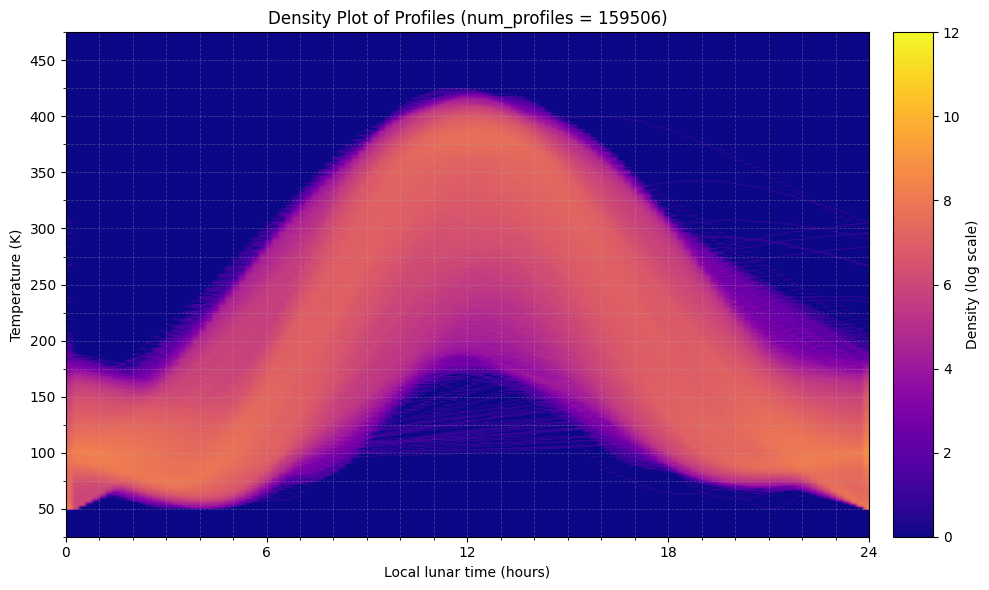

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [5]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 196.1697
STD: 97.4493
Min Temp: 50.0000
Max Temp: 424.8680
Datasets:
Training Data: 111654
Validation Data: 31901
Test Data: 15951


In [6]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 559/559 [00:18<00:00, 30.25it/s, best_loss=0.6261]


[Training] Epoch 1/100, L1 Loss: 0.6362, L2 Loss: 0.6735, KL Loss: 0.5090, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 160/160 [00:01<00:00, 107.71it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5466, Val L2 Loss: 0.5524, Val KL Loss: 0.6241
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_100-5d_20250802_2000'


[Training] Epoch 2/100: 100%|██████████| 559/559 [00:18<00:00, 30.48it/s, best_loss=0.6245]


[Training] Epoch 2/100, L1 Loss: 0.5860, L2 Loss: 0.5976, KL Loss: 0.6383, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 160/160 [00:01<00:00, 98.39it/s] 


[Validation] Epoch 2/100, Val L1 Loss: 0.5382, Val L2 Loss: 0.5466, Val KL Loss: 0.6412
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_100-5d_20250802_2000'


[Training] Epoch 3/100: 100%|██████████| 559/559 [00:18<00:00, 30.33it/s, best_loss=0.6016]


[Training] Epoch 3/100, L1 Loss: 0.5848, L2 Loss: 0.5963, KL Loss: 0.6409, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 160/160 [00:01<00:00, 105.87it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.5338, Val L2 Loss: 0.5430, Val KL Loss: 0.6483
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_100-5d_20250802_2000'


[Training] Epoch 4/100: 100%|██████████| 559/559 [00:18<00:00, 29.88it/s, best_loss=0.6238]


[Training] Epoch 4/100, L1 Loss: 0.5843, L2 Loss: 0.5955, KL Loss: 0.6398, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 160/160 [00:01<00:00, 105.96it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5393, Val L2 Loss: 0.5473, Val KL Loss: 0.6369


[Training] Epoch 5/100: 100%|██████████| 559/559 [00:18<00:00, 30.14it/s, best_loss=0.6134]


[Training] Epoch 5/100, L1 Loss: 0.5846, L2 Loss: 0.5958, KL Loss: 0.6399, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 160/160 [00:01<00:00, 103.16it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.5341, Val L2 Loss: 0.5435, Val KL Loss: 0.6461


[Training] Epoch 6/100: 100%|██████████| 559/559 [00:18<00:00, 30.20it/s, best_loss=0.6031]


[Training] Epoch 6/100, L1 Loss: 0.5850, L2 Loss: 0.5965, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 160/160 [00:01<00:00, 105.51it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5377, Val L2 Loss: 0.5453, Val KL Loss: 0.6413


[Training] Epoch 7/100: 100%|██████████| 559/559 [00:18<00:00, 30.02it/s, best_loss=0.6158]


[Training] Epoch 7/100, L1 Loss: 0.5846, L2 Loss: 0.5958, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 160/160 [00:01<00:00, 109.35it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.5386, Val L2 Loss: 0.5461, Val KL Loss: 0.6370


[Training] Epoch 8/100: 100%|██████████| 559/559 [00:18<00:00, 30.27it/s, best_loss=0.6053]


[Training] Epoch 8/100, L1 Loss: 0.5848, L2 Loss: 0.5962, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 160/160 [00:01<00:00, 103.62it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5355, Val L2 Loss: 0.5446, Val KL Loss: 0.6401


[Training] Epoch 9/100: 100%|██████████| 559/559 [00:18<00:00, 30.37it/s, best_loss=0.6167]


[Training] Epoch 9/100, L1 Loss: 0.5843, L2 Loss: 0.5956, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 160/160 [00:01<00:00, 106.23it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.5364, Val L2 Loss: 0.5448, Val KL Loss: 0.6441


[Training] Epoch 10/100: 100%|██████████| 559/559 [00:18<00:00, 29.91it/s, best_loss=0.5997]


[Training] Epoch 10/100, L1 Loss: 0.5849, L2 Loss: 0.5963, KL Loss: 0.6399, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 160/160 [00:01<00:00, 106.18it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5352, Val L2 Loss: 0.5444, Val KL Loss: 0.6389


[Training] Epoch 11/100: 100%|██████████| 559/559 [00:18<00:00, 30.29it/s, best_loss=0.6159]


[Training] Epoch 11/100, L1 Loss: 0.5847, L2 Loss: 0.5962, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 160/160 [00:01<00:00, 109.17it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5369, Val L2 Loss: 0.5454, Val KL Loss: 0.6372


[Training] Epoch 12/100: 100%|██████████| 559/559 [00:18<00:00, 30.17it/s, best_loss=0.6194]


[Training] Epoch 12/100, L1 Loss: 0.5845, L2 Loss: 0.5959, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 160/160 [00:01<00:00, 103.10it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5354, Val L2 Loss: 0.5445, Val KL Loss: 0.6406


[Training] Epoch 13/100: 100%|██████████| 559/559 [00:18<00:00, 30.02it/s, best_loss=0.6223]


[Training] Epoch 13/100, L1 Loss: 0.5844, L2 Loss: 0.5958, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 160/160 [00:01<00:00, 99.66it/s] 


[Validation] Epoch 13/100, Val L1 Loss: 0.5377, Val L2 Loss: 0.5459, Val KL Loss: 0.6368


[Training] Epoch 14/100: 100%|██████████| 559/559 [00:18<00:00, 30.49it/s, best_loss=0.6078]


[Training] Epoch 14/100, L1 Loss: 0.5847, L2 Loss: 0.5960, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 160/160 [00:01<00:00, 106.52it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5357, Val L2 Loss: 0.5447, Val KL Loss: 0.6422


[Training] Epoch 15/100: 100%|██████████| 559/559 [00:18<00:00, 30.23it/s, best_loss=0.6281]


[Training] Epoch 15/100, L1 Loss: 0.5845, L2 Loss: 0.5956, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 160/160 [00:01<00:00, 106.79it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5424, Val L2 Loss: 0.5496, Val KL Loss: 0.6280


[Training] Epoch 16/100: 100%|██████████| 559/559 [00:18<00:00, 30.04it/s, best_loss=0.6150]


[Training] Epoch 16/100, L1 Loss: 0.5847, L2 Loss: 0.5961, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 160/160 [00:01<00:00, 105.00it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5383, Val L2 Loss: 0.5462, Val KL Loss: 0.6326


[Training] Epoch 17/100: 100%|██████████| 559/559 [00:18<00:00, 30.32it/s, best_loss=0.6177]


[Training] Epoch 17/100, L1 Loss: 0.5845, L2 Loss: 0.5959, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 160/160 [00:01<00:00, 103.88it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5383, Val L2 Loss: 0.5462, Val KL Loss: 0.6384


[Training] Epoch 18/100: 100%|██████████| 559/559 [00:18<00:00, 30.48it/s, best_loss=0.6169]


[Training] Epoch 18/100, L1 Loss: 0.5846, L2 Loss: 0.5961, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 160/160 [00:01<00:00, 105.85it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5395, Val L2 Loss: 0.5472, Val KL Loss: 0.6335


[Training] Epoch 19/100: 100%|██████████| 559/559 [00:18<00:00, 29.89it/s, best_loss=0.6279]


[Training] Epoch 19/100, L1 Loss: 0.5846, L2 Loss: 0.5959, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 160/160 [00:01<00:00, 103.11it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5385, Val L2 Loss: 0.5462, Val KL Loss: 0.6378


[Training] Epoch 20/100: 100%|██████████| 559/559 [00:18<00:00, 30.13it/s, best_loss=0.6113]


[Training] Epoch 20/100, L1 Loss: 0.5846, L2 Loss: 0.5961, KL Loss: 0.6397, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 160/160 [00:01<00:00, 103.49it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5368, Val L2 Loss: 0.5453, Val KL Loss: 0.6367


[Training] Epoch 21/100: 100%|██████████| 559/559 [00:18<00:00, 30.23it/s, best_loss=0.5940]


[Training] Epoch 21/100, L1 Loss: 0.5845, L2 Loss: 0.5958, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 160/160 [00:01<00:00, 104.86it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5337, Val L2 Loss: 0.5432, Val KL Loss: 0.6467
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_100-5d_20250802_2000'


[Training] Epoch 22/100: 100%|██████████| 559/559 [00:18<00:00, 29.84it/s, best_loss=0.6206]


[Training] Epoch 22/100, L1 Loss: 0.5846, L2 Loss: 0.5961, KL Loss: 0.6397, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 160/160 [00:01<00:00, 100.60it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5373, Val L2 Loss: 0.5457, Val KL Loss: 0.6358


[Training] Epoch 23/100: 100%|██████████| 559/559 [00:18<00:00, 30.42it/s, best_loss=0.6083]


[Training] Epoch 23/100, L1 Loss: 0.5845, L2 Loss: 0.5958, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 160/160 [00:01<00:00, 105.17it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5371, Val L2 Loss: 0.5454, Val KL Loss: 0.6397


[Training] Epoch 24/100: 100%|██████████| 559/559 [00:18<00:00, 30.05it/s, best_loss=0.6347]


[Training] Epoch 24/100, L1 Loss: 0.5846, L2 Loss: 0.5960, KL Loss: 0.6399, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 160/160 [00:01<00:00, 106.70it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5343, Val L2 Loss: 0.5433, Val KL Loss: 0.6434


[Training] Epoch 25/100: 100%|██████████| 559/559 [00:19<00:00, 28.98it/s, best_loss=0.5937]


[Training] Epoch 25/100, L1 Loss: 0.5845, L2 Loss: 0.5960, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 160/160 [00:01<00:00, 97.28it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.5382, Val L2 Loss: 0.5462, Val KL Loss: 0.6345


[Training] Epoch 26/100: 100%|██████████| 559/559 [00:18<00:00, 29.51it/s, best_loss=0.6136]


[Training] Epoch 26/100, L1 Loss: 0.5847, L2 Loss: 0.5960, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 160/160 [00:01<00:00, 102.99it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5381, Val L2 Loss: 0.5463, Val KL Loss: 0.6390


[Training] Epoch 27/100: 100%|██████████| 559/559 [00:18<00:00, 30.47it/s, best_loss=0.5910]


[Training] Epoch 27/100, L1 Loss: 0.5845, L2 Loss: 0.5957, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 160/160 [00:01<00:00, 106.32it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5397, Val L2 Loss: 0.5475, Val KL Loss: 0.6315


[Training] Epoch 28/100: 100%|██████████| 559/559 [00:18<00:00, 29.56it/s, best_loss=0.6187]


[Training] Epoch 28/100, L1 Loss: 0.5850, L2 Loss: 0.5964, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 160/160 [00:01<00:00, 98.15it/s] 


[Validation] Epoch 28/100, Val L1 Loss: 0.5341, Val L2 Loss: 0.5436, Val KL Loss: 0.6444


[Training] Epoch 29/100: 100%|██████████| 559/559 [00:18<00:00, 30.02it/s, best_loss=0.5985]


[Training] Epoch 29/100, L1 Loss: 0.5841, L2 Loss: 0.5953, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 160/160 [00:01<00:00, 104.66it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5369, Val L2 Loss: 0.5450, Val KL Loss: 0.6368


[Training] Epoch 30/100: 100%|██████████| 559/559 [00:18<00:00, 30.35it/s, best_loss=0.6357]


[Training] Epoch 30/100, L1 Loss: 0.5843, L2 Loss: 0.5957, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 160/160 [00:01<00:00, 103.57it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5337, Val L2 Loss: 0.5432, Val KL Loss: 0.6495


[Training] Epoch 31/100: 100%|██████████| 559/559 [00:18<00:00, 30.22it/s, best_loss=0.6194]


[Training] Epoch 31/100, L1 Loss: 0.5842, L2 Loss: 0.5954, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 160/160 [00:01<00:00, 103.99it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.5348, Val L2 Loss: 0.5438, Val KL Loss: 0.6431


[Training] Epoch 32/100: 100%|██████████| 559/559 [00:18<00:00, 29.75it/s, best_loss=0.6313]


[Training] Epoch 32/100, L1 Loss: 0.5843, L2 Loss: 0.5954, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 160/160 [00:01<00:00, 104.95it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5406, Val L2 Loss: 0.5479, Val KL Loss: 0.6316


[Training] Epoch 33/100: 100%|██████████| 559/559 [00:18<00:00, 30.01it/s, best_loss=0.5935]


[Training] Epoch 33/100, L1 Loss: 0.5844, L2 Loss: 0.5953, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 160/160 [00:01<00:00, 98.33it/s] 


[Validation] Epoch 33/100, Val L1 Loss: 0.5342, Val L2 Loss: 0.5433, Val KL Loss: 0.6457


[Training] Epoch 34/100: 100%|██████████| 559/559 [00:18<00:00, 29.89it/s, best_loss=0.6246]


[Training] Epoch 34/100, L1 Loss: 0.5849, L2 Loss: 0.5961, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 160/160 [00:01<00:00, 105.12it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5357, Val L2 Loss: 0.5448, Val KL Loss: 0.6378


[Training] Epoch 35/100: 100%|██████████| 559/559 [00:18<00:00, 29.70it/s, best_loss=0.6347]


[Training] Epoch 35/100, L1 Loss: 0.5845, L2 Loss: 0.5959, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 160/160 [00:01<00:00, 105.91it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5364, Val L2 Loss: 0.5450, Val KL Loss: 0.6394


[Training] Epoch 36/100: 100%|██████████| 559/559 [00:18<00:00, 30.63it/s, best_loss=0.6089]


[Training] Epoch 36/100, L1 Loss: 0.5842, L2 Loss: 0.5957, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 160/160 [00:01<00:00, 104.41it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5380, Val L2 Loss: 0.5460, Val KL Loss: 0.6394


[Training] Epoch 37/100: 100%|██████████| 559/559 [00:18<00:00, 30.03it/s, best_loss=0.6171]


[Training] Epoch 37/100, L1 Loss: 0.5847, L2 Loss: 0.5961, KL Loss: 0.6397, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 160/160 [00:01<00:00, 104.46it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5384, Val L2 Loss: 0.5465, Val KL Loss: 0.6337


[Training] Epoch 38/100: 100%|██████████| 559/559 [00:18<00:00, 29.90it/s, best_loss=0.6084]


[Training] Epoch 38/100, L1 Loss: 0.5847, L2 Loss: 0.5962, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 160/160 [00:01<00:00, 103.61it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5359, Val L2 Loss: 0.5446, Val KL Loss: 0.6406


[Training] Epoch 39/100: 100%|██████████| 559/559 [00:18<00:00, 29.54it/s, best_loss=0.6317]


[Training] Epoch 39/100, L1 Loss: 0.5845, L2 Loss: 0.5961, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 160/160 [00:01<00:00, 106.25it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5379, Val L2 Loss: 0.5459, Val KL Loss: 0.6330


[Training] Epoch 40/100: 100%|██████████| 559/559 [00:19<00:00, 28.27it/s, best_loss=0.6221]


[Training] Epoch 40/100, L1 Loss: 0.5843, L2 Loss: 0.5956, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 160/160 [00:01<00:00, 98.82it/s] 


[Validation] Epoch 40/100, Val L1 Loss: 0.5365, Val L2 Loss: 0.5453, Val KL Loss: 0.6404


[Training] Epoch 41/100: 100%|██████████| 559/559 [00:19<00:00, 28.20it/s, best_loss=0.6328]


[Training] Epoch 41/100, L1 Loss: 0.5844, L2 Loss: 0.5958, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 160/160 [00:01<00:00, 97.48it/s] 


[Validation] Epoch 41/100, Val L1 Loss: 0.5390, Val L2 Loss: 0.5467, Val KL Loss: 0.6382


[Training] Epoch 42/100: 100%|██████████| 559/559 [00:19<00:00, 28.70it/s, best_loss=0.6132]


[Training] Epoch 42/100, L1 Loss: 0.5850, L2 Loss: 0.5964, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 160/160 [00:01<00:00, 88.88it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5380, Val L2 Loss: 0.5464, Val KL Loss: 0.6350


[Training] Epoch 43/100: 100%|██████████| 559/559 [00:19<00:00, 28.29it/s, best_loss=0.6149]


[Training] Epoch 43/100, L1 Loss: 0.5846, L2 Loss: 0.5958, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 160/160 [00:01<00:00, 97.02it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5320, Val L2 Loss: 0.5417, Val KL Loss: 0.6487
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_100-5d_20250802_2000'


[Training] Epoch 44/100: 100%|██████████| 559/559 [00:19<00:00, 28.23it/s, best_loss=0.6257]


[Training] Epoch 44/100, L1 Loss: 0.5844, L2 Loss: 0.5957, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 160/160 [00:01<00:00, 96.77it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.5351, Val L2 Loss: 0.5442, Val KL Loss: 0.6440


[Training] Epoch 45/100: 100%|██████████| 559/559 [00:19<00:00, 28.34it/s, best_loss=0.6259]


[Training] Epoch 45/100, L1 Loss: 0.5848, L2 Loss: 0.5961, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 160/160 [00:01<00:00, 96.53it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5380, Val L2 Loss: 0.5461, Val KL Loss: 0.6332


[Training] Epoch 46/100: 100%|██████████| 559/559 [00:19<00:00, 28.69it/s, best_loss=0.6076]


[Training] Epoch 46/100, L1 Loss: 0.5847, L2 Loss: 0.5962, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 160/160 [00:01<00:00, 98.84it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5366, Val L2 Loss: 0.5452, Val KL Loss: 0.6368


[Training] Epoch 47/100: 100%|██████████| 559/559 [00:20<00:00, 27.73it/s, best_loss=0.6138]


[Training] Epoch 47/100, L1 Loss: 0.5846, L2 Loss: 0.5960, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 160/160 [00:01<00:00, 99.91it/s] 


[Validation] Epoch 47/100, Val L1 Loss: 0.5346, Val L2 Loss: 0.5437, Val KL Loss: 0.6477


[Training] Epoch 48/100: 100%|██████████| 559/559 [00:19<00:00, 28.46it/s, best_loss=0.6370]


[Training] Epoch 48/100, L1 Loss: 0.5846, L2 Loss: 0.5960, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 160/160 [00:01<00:00, 97.14it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5390, Val L2 Loss: 0.5475, Val KL Loss: 0.6337


[Training] Epoch 49/100: 100%|██████████| 559/559 [00:19<00:00, 28.87it/s, best_loss=0.6079]


[Training] Epoch 49/100, L1 Loss: 0.5848, L2 Loss: 0.5960, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 160/160 [00:01<00:00, 95.25it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5378, Val L2 Loss: 0.5460, Val KL Loss: 0.6360


[Training] Epoch 50/100: 100%|██████████| 559/559 [00:19<00:00, 28.89it/s, best_loss=0.6245]


[Training] Epoch 50/100, L1 Loss: 0.5847, L2 Loss: 0.5961, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 160/160 [00:01<00:00, 101.15it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5360, Val L2 Loss: 0.5445, Val KL Loss: 0.6392


[Training] Epoch 51/100: 100%|██████████| 559/559 [00:19<00:00, 28.88it/s, best_loss=0.6307]


[Training] Epoch 51/100, L1 Loss: 0.5849, L2 Loss: 0.5962, KL Loss: 0.6399, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 160/160 [00:01<00:00, 99.51it/s] 


[Validation] Epoch 51/100, Val L1 Loss: 0.5347, Val L2 Loss: 0.5438, Val KL Loss: 0.6467


[Training] Epoch 52/100: 100%|██████████| 559/559 [00:19<00:00, 28.48it/s, best_loss=0.6264]


[Training] Epoch 52/100, L1 Loss: 0.5849, L2 Loss: 0.5962, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 160/160 [00:01<00:00, 99.90it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5359, Val L2 Loss: 0.5448, Val KL Loss: 0.6417


[Training] Epoch 53/100: 100%|██████████| 559/559 [00:19<00:00, 28.78it/s, best_loss=0.6224]


[Training] Epoch 53/100, L1 Loss: 0.5847, L2 Loss: 0.5962, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 160/160 [00:01<00:00, 95.80it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5371, Val L2 Loss: 0.5457, Val KL Loss: 0.6374


[Training] Epoch 54/100: 100%|██████████| 559/559 [00:19<00:00, 28.73it/s, best_loss=0.6017]


[Training] Epoch 54/100, L1 Loss: 0.5846, L2 Loss: 0.5960, KL Loss: 0.6399, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 160/160 [00:01<00:00, 99.12it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5407, Val L2 Loss: 0.5479, Val KL Loss: 0.6328


[Training] Epoch 55/100: 100%|██████████| 559/559 [00:19<00:00, 28.52it/s, best_loss=0.6198]


[Training] Epoch 55/100, L1 Loss: 0.5842, L2 Loss: 0.5955, KL Loss: 0.6399, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 160/160 [00:01<00:00, 98.37it/s] 


[Validation] Epoch 55/100, Val L1 Loss: 0.5392, Val L2 Loss: 0.5472, Val KL Loss: 0.6354


[Training] Epoch 56/100: 100%|██████████| 559/559 [00:19<00:00, 28.73it/s, best_loss=0.6249]


[Training] Epoch 56/100, L1 Loss: 0.5848, L2 Loss: 0.5960, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 160/160 [00:01<00:00, 100.18it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5373, Val L2 Loss: 0.5456, Val KL Loss: 0.6418


[Training] Epoch 57/100: 100%|██████████| 559/559 [00:19<00:00, 28.66it/s, best_loss=0.6248]


[Training] Epoch 57/100, L1 Loss: 0.5843, L2 Loss: 0.5956, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 160/160 [00:01<00:00, 100.56it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.5338, Val L2 Loss: 0.5434, Val KL Loss: 0.6473


[Training] Epoch 58/100: 100%|██████████| 559/559 [00:19<00:00, 28.83it/s, best_loss=0.6175]


[Training] Epoch 58/100, L1 Loss: 0.5847, L2 Loss: 0.5960, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 160/160 [00:01<00:00, 100.35it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5339, Val L2 Loss: 0.5432, Val KL Loss: 0.6406


[Training] Epoch 59/100: 100%|██████████| 559/559 [00:19<00:00, 28.39it/s, best_loss=0.6331]


[Training] Epoch 59/100, L1 Loss: 0.5844, L2 Loss: 0.5956, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 160/160 [00:01<00:00, 99.57it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5344, Val L2 Loss: 0.5434, Val KL Loss: 0.6483


[Training] Epoch 60/100: 100%|██████████| 559/559 [00:19<00:00, 28.84it/s, best_loss=0.6180]


[Training] Epoch 60/100, L1 Loss: 0.5843, L2 Loss: 0.5952, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 160/160 [00:01<00:00, 101.75it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5389, Val L2 Loss: 0.5467, Val KL Loss: 0.6383


[Training] Epoch 61/100: 100%|██████████| 559/559 [00:19<00:00, 28.41it/s, best_loss=0.6193]


[Training] Epoch 61/100, L1 Loss: 0.5845, L2 Loss: 0.5959, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 160/160 [00:01<00:00, 100.49it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5392, Val L2 Loss: 0.5472, Val KL Loss: 0.6348


[Training] Epoch 62/100: 100%|██████████| 559/559 [00:19<00:00, 28.81it/s, best_loss=0.6031]


[Training] Epoch 62/100, L1 Loss: 0.5846, L2 Loss: 0.5958, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 160/160 [00:01<00:00, 100.47it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5416, Val L2 Loss: 0.5489, Val KL Loss: 0.6257


[Training] Epoch 63/100: 100%|██████████| 559/559 [00:19<00:00, 28.96it/s, best_loss=0.6071]


[Training] Epoch 63/100, L1 Loss: 0.5848, L2 Loss: 0.5963, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 160/160 [00:01<00:00, 99.82it/s] 


[Validation] Epoch 63/100, Val L1 Loss: 0.5375, Val L2 Loss: 0.5455, Val KL Loss: 0.6420


[Training] Epoch 64/100: 100%|██████████| 559/559 [00:19<00:00, 28.81it/s, best_loss=0.6113]


[Training] Epoch 64/100, L1 Loss: 0.5846, L2 Loss: 0.5960, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 160/160 [00:01<00:00, 96.08it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5352, Val L2 Loss: 0.5444, Val KL Loss: 0.6437


[Training] Epoch 65/100: 100%|██████████| 559/559 [00:19<00:00, 28.20it/s, best_loss=0.6251]


[Training] Epoch 65/100, L1 Loss: 0.5845, L2 Loss: 0.5959, KL Loss: 0.6397, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 160/160 [00:01<00:00, 100.52it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.5343, Val L2 Loss: 0.5433, Val KL Loss: 0.6515


[Training] Epoch 66/100: 100%|██████████| 559/559 [00:19<00:00, 28.41it/s, best_loss=0.6192]


[Training] Epoch 66/100, L1 Loss: 0.5846, L2 Loss: 0.5960, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 160/160 [00:01<00:00, 99.91it/s] 


[Validation] Epoch 66/100, Val L1 Loss: 0.5392, Val L2 Loss: 0.5472, Val KL Loss: 0.6346


[Training] Epoch 67/100: 100%|██████████| 559/559 [00:19<00:00, 28.62it/s, best_loss=0.6025]


[Training] Epoch 67/100, L1 Loss: 0.5846, L2 Loss: 0.5958, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 160/160 [00:01<00:00, 99.49it/s] 


[Validation] Epoch 67/100, Val L1 Loss: 0.5366, Val L2 Loss: 0.5456, Val KL Loss: 0.6418


[Training] Epoch 68/100: 100%|██████████| 559/559 [00:19<00:00, 28.22it/s, best_loss=0.6230]


[Training] Epoch 68/100, L1 Loss: 0.5845, L2 Loss: 0.5959, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 160/160 [00:01<00:00, 99.43it/s] 


[Validation] Epoch 68/100, Val L1 Loss: 0.5339, Val L2 Loss: 0.5433, Val KL Loss: 0.6502


[Training] Epoch 69/100: 100%|██████████| 559/559 [00:19<00:00, 28.63it/s, best_loss=0.6122]


[Training] Epoch 69/100, L1 Loss: 0.5848, L2 Loss: 0.5964, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 160/160 [00:01<00:00, 100.86it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5333, Val L2 Loss: 0.5429, Val KL Loss: 0.6456


[Training] Epoch 70/100: 100%|██████████| 559/559 [00:19<00:00, 28.37it/s, best_loss=0.6146]


[Training] Epoch 70/100, L1 Loss: 0.5845, L2 Loss: 0.5958, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 160/160 [00:01<00:00, 99.69it/s] 


[Validation] Epoch 70/100, Val L1 Loss: 0.5355, Val L2 Loss: 0.5445, Val KL Loss: 0.6395


[Training] Epoch 71/100: 100%|██████████| 559/559 [00:19<00:00, 28.23it/s, best_loss=0.5965]


[Training] Epoch 71/100, L1 Loss: 0.5845, L2 Loss: 0.5958, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 160/160 [00:01<00:00, 102.01it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5355, Val L2 Loss: 0.5443, Val KL Loss: 0.6456


[Training] Epoch 72/100: 100%|██████████| 559/559 [00:19<00:00, 28.42it/s, best_loss=0.6164]


[Training] Epoch 72/100, L1 Loss: 0.5845, L2 Loss: 0.5959, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 160/160 [00:01<00:00, 97.06it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5411, Val L2 Loss: 0.5488, Val KL Loss: 0.6289


[Training] Epoch 73/100: 100%|██████████| 559/559 [00:19<00:00, 28.27it/s, best_loss=0.6229]


[Training] Epoch 73/100, L1 Loss: 0.5844, L2 Loss: 0.5958, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 160/160 [00:01<00:00, 94.52it/s] 


[Validation] Epoch 73/100, Val L1 Loss: 0.5341, Val L2 Loss: 0.5431, Val KL Loss: 0.6436


[Training] Epoch 74/100: 100%|██████████| 559/559 [00:19<00:00, 28.49it/s, best_loss=0.5947]


[Training] Epoch 74/100, L1 Loss: 0.5849, L2 Loss: 0.5964, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 160/160 [00:01<00:00, 98.99it/s] 


[Validation] Epoch 74/100, Val L1 Loss: 0.5394, Val L2 Loss: 0.5470, Val KL Loss: 0.6324


[Training] Epoch 75/100: 100%|██████████| 559/559 [00:19<00:00, 27.96it/s, best_loss=0.6293]


[Training] Epoch 75/100, L1 Loss: 0.5846, L2 Loss: 0.5961, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 160/160 [00:01<00:00, 96.17it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5382, Val L2 Loss: 0.5462, Val KL Loss: 0.6382


[Training] Epoch 76/100: 100%|██████████| 559/559 [00:20<00:00, 27.72it/s, best_loss=0.6165]


[Training] Epoch 76/100, L1 Loss: 0.5844, L2 Loss: 0.5959, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 160/160 [00:01<00:00, 96.15it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5415, Val KL Loss: 0.6519
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_100-5d_20250802_2000'


[Training] Epoch 77/100: 100%|██████████| 559/559 [00:20<00:00, 27.83it/s, best_loss=0.6302]


[Training] Epoch 77/100, L1 Loss: 0.5845, L2 Loss: 0.5958, KL Loss: 0.6399, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 160/160 [00:01<00:00, 97.29it/s] 


[Validation] Epoch 77/100, Val L1 Loss: 0.5385, Val L2 Loss: 0.5467, Val KL Loss: 0.6310


[Training] Epoch 78/100: 100%|██████████| 559/559 [00:19<00:00, 28.50it/s, best_loss=0.6196]


[Training] Epoch 78/100, L1 Loss: 0.5843, L2 Loss: 0.5957, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 160/160 [00:01<00:00, 102.15it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5354, Val L2 Loss: 0.5444, Val KL Loss: 0.6393


[Training] Epoch 79/100: 100%|██████████| 559/559 [00:20<00:00, 27.70it/s, best_loss=0.6384]


[Training] Epoch 79/100, L1 Loss: 0.5847, L2 Loss: 0.5964, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 160/160 [00:01<00:00, 99.00it/s] 


[Validation] Epoch 79/100, Val L1 Loss: 0.5336, Val L2 Loss: 0.5428, Val KL Loss: 0.6469


[Training] Epoch 80/100: 100%|██████████| 559/559 [00:19<00:00, 28.34it/s, best_loss=0.6253]


[Training] Epoch 80/100, L1 Loss: 0.5845, L2 Loss: 0.5958, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 160/160 [00:01<00:00, 100.22it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5370, Val L2 Loss: 0.5454, Val KL Loss: 0.6368


[Training] Epoch 81/100: 100%|██████████| 559/559 [00:19<00:00, 28.49it/s, best_loss=0.6160]


[Training] Epoch 81/100, L1 Loss: 0.5846, L2 Loss: 0.5961, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 160/160 [00:01<00:00, 98.22it/s] 


[Validation] Epoch 81/100, Val L1 Loss: 0.5399, Val L2 Loss: 0.5474, Val KL Loss: 0.6324


[Training] Epoch 82/100: 100%|██████████| 559/559 [00:19<00:00, 28.06it/s, best_loss=0.6092]


[Training] Epoch 82/100, L1 Loss: 0.5842, L2 Loss: 0.5956, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 160/160 [00:01<00:00, 99.90it/s] 


[Validation] Epoch 82/100, Val L1 Loss: 0.5339, Val L2 Loss: 0.5432, Val KL Loss: 0.6481


[Training] Epoch 83/100: 100%|██████████| 559/559 [00:19<00:00, 28.52it/s, best_loss=0.6374]


[Training] Epoch 83/100, L1 Loss: 0.5847, L2 Loss: 0.5962, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 160/160 [00:01<00:00, 99.49it/s] 


[Validation] Epoch 83/100, Val L1 Loss: 0.5345, Val L2 Loss: 0.5436, Val KL Loss: 0.6430


[Training] Epoch 84/100: 100%|██████████| 559/559 [00:19<00:00, 28.64it/s, best_loss=0.6212]


[Training] Epoch 84/100, L1 Loss: 0.5847, L2 Loss: 0.5960, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 160/160 [00:01<00:00, 95.39it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5343, Val L2 Loss: 0.5430, Val KL Loss: 0.6462


[Training] Epoch 85/100: 100%|██████████| 559/559 [00:19<00:00, 28.59it/s, best_loss=0.6221]


[Training] Epoch 85/100, L1 Loss: 0.5845, L2 Loss: 0.5957, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 160/160 [00:01<00:00, 98.83it/s] 


[Validation] Epoch 85/100, Val L1 Loss: 0.5403, Val L2 Loss: 0.5475, Val KL Loss: 0.6340


[Training] Epoch 86/100: 100%|██████████| 559/559 [00:19<00:00, 28.51it/s, best_loss=0.6111]


[Training] Epoch 86/100, L1 Loss: 0.5847, L2 Loss: 0.5960, KL Loss: 0.6399, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 160/160 [00:01<00:00, 99.90it/s] 


[Validation] Epoch 86/100, Val L1 Loss: 0.5371, Val L2 Loss: 0.5455, Val KL Loss: 0.6368


[Training] Epoch 87/100: 100%|██████████| 559/559 [00:19<00:00, 28.80it/s, best_loss=0.5983]


[Training] Epoch 87/100, L1 Loss: 0.5842, L2 Loss: 0.5956, KL Loss: 0.6399, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 160/160 [00:01<00:00, 98.32it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5441, Val L2 Loss: 0.5504, Val KL Loss: 0.6240


[Training] Epoch 88/100: 100%|██████████| 559/559 [00:19<00:00, 28.54it/s, best_loss=0.6100]


[Training] Epoch 88/100, L1 Loss: 0.5847, L2 Loss: 0.5962, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 160/160 [00:01<00:00, 102.70it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5385, Val L2 Loss: 0.5464, Val KL Loss: 0.6372


[Training] Epoch 89/100: 100%|██████████| 559/559 [00:19<00:00, 28.70it/s, best_loss=0.6106]


[Training] Epoch 89/100, L1 Loss: 0.5845, L2 Loss: 0.5961, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 160/160 [00:01<00:00, 98.80it/s] 


[Validation] Epoch 89/100, Val L1 Loss: 0.5389, Val L2 Loss: 0.5467, Val KL Loss: 0.6343


[Training] Epoch 90/100: 100%|██████████| 559/559 [00:19<00:00, 28.01it/s, best_loss=0.6169]


[Training] Epoch 90/100, L1 Loss: 0.5845, L2 Loss: 0.5959, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 160/160 [00:01<00:00, 93.98it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5389, Val L2 Loss: 0.5470, Val KL Loss: 0.6306


[Training] Epoch 91/100: 100%|██████████| 559/559 [00:19<00:00, 28.60it/s, best_loss=0.6141]


[Training] Epoch 91/100, L1 Loss: 0.5846, L2 Loss: 0.5959, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 160/160 [00:01<00:00, 101.62it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5389, Val L2 Loss: 0.5466, Val KL Loss: 0.6331


[Training] Epoch 92/100: 100%|██████████| 559/559 [00:19<00:00, 28.50it/s, best_loss=0.6172]


[Training] Epoch 92/100, L1 Loss: 0.5844, L2 Loss: 0.5956, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 160/160 [00:01<00:00, 109.67it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5391, Val L2 Loss: 0.5472, Val KL Loss: 0.6316


[Training] Epoch 93/100: 100%|██████████| 559/559 [00:18<00:00, 30.26it/s, best_loss=0.6082]


[Training] Epoch 93/100, L1 Loss: 0.5848, L2 Loss: 0.5962, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 160/160 [00:01<00:00, 87.82it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5367, Val L2 Loss: 0.5450, Val KL Loss: 0.6432


[Training] Epoch 94/100: 100%|██████████| 559/559 [00:19<00:00, 29.28it/s, best_loss=0.6400]


[Training] Epoch 94/100, L1 Loss: 0.5847, L2 Loss: 0.5962, KL Loss: 0.6399, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 160/160 [00:01<00:00, 100.08it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5402, Val L2 Loss: 0.5478, Val KL Loss: 0.6335


[Training] Epoch 95/100: 100%|██████████| 559/559 [00:19<00:00, 29.04it/s, best_loss=0.6263]


[Training] Epoch 95/100, L1 Loss: 0.5846, L2 Loss: 0.5960, KL Loss: 0.6397, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 160/160 [00:01<00:00, 94.95it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5377, Val L2 Loss: 0.5455, Val KL Loss: 0.6377


[Training] Epoch 96/100: 100%|██████████| 559/559 [00:19<00:00, 28.47it/s, best_loss=0.6250]


[Training] Epoch 96/100, L1 Loss: 0.5848, L2 Loss: 0.5964, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 160/160 [00:01<00:00, 97.97it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5371, Val L2 Loss: 0.5454, Val KL Loss: 0.6372


[Training] Epoch 97/100: 100%|██████████| 559/559 [00:19<00:00, 28.30it/s, best_loss=0.6166]


[Training] Epoch 97/100, L1 Loss: 0.5844, L2 Loss: 0.5957, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 160/160 [00:01<00:00, 92.61it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5392, Val L2 Loss: 0.5470, Val KL Loss: 0.6312


[Training] Epoch 98/100: 100%|██████████| 559/559 [00:19<00:00, 28.75it/s, best_loss=0.6321]


[Training] Epoch 98/100, L1 Loss: 0.5847, L2 Loss: 0.5961, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 160/160 [00:01<00:00, 100.13it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5371, Val L2 Loss: 0.5453, Val KL Loss: 0.6389


[Training] Epoch 99/100: 100%|██████████| 559/559 [00:19<00:00, 28.50it/s, best_loss=0.6151]


[Training] Epoch 99/100, L1 Loss: 0.5846, L2 Loss: 0.5959, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 160/160 [00:01<00:00, 100.38it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5394, Val L2 Loss: 0.5470, Val KL Loss: 0.6349


[Training] Epoch 100/100: 100%|██████████| 559/559 [00:19<00:00, 28.56it/s, best_loss=0.6279]


[Training] Epoch 100/100, L1 Loss: 0.5846, L2 Loss: 0.5961, KL Loss: 0.6398, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 160/160 [00:01<00:00, 101.03it/s]


[Validation] Epoch 100/100, Val L1 Loss: 0.5361, Val L2 Loss: 0.5449, Val KL Loss: 0.6414


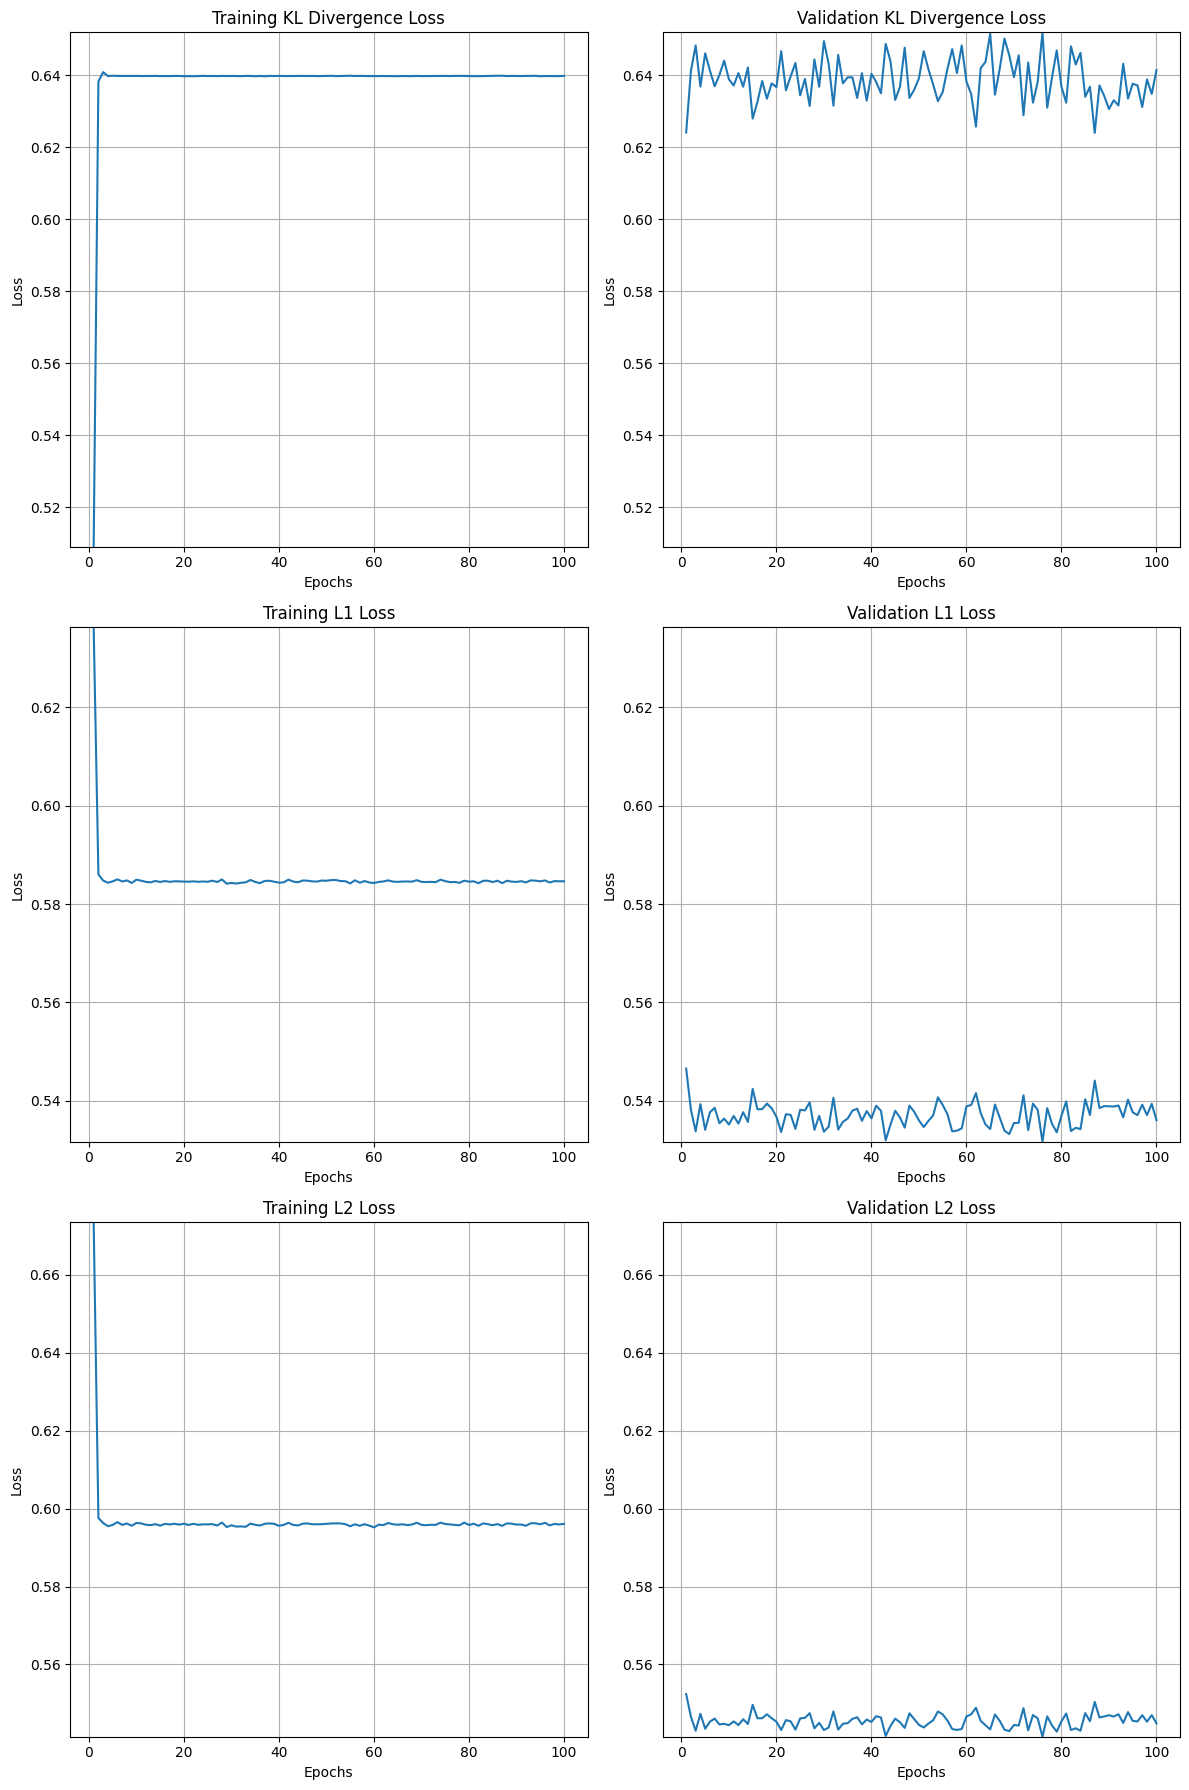

Best Validation Loss in Kelvins:
51.8141 K


In [7]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


z0: 0.0349
z1: 0.0050
z2: 0.0024
z3: -0.0238


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 796.54it/s]


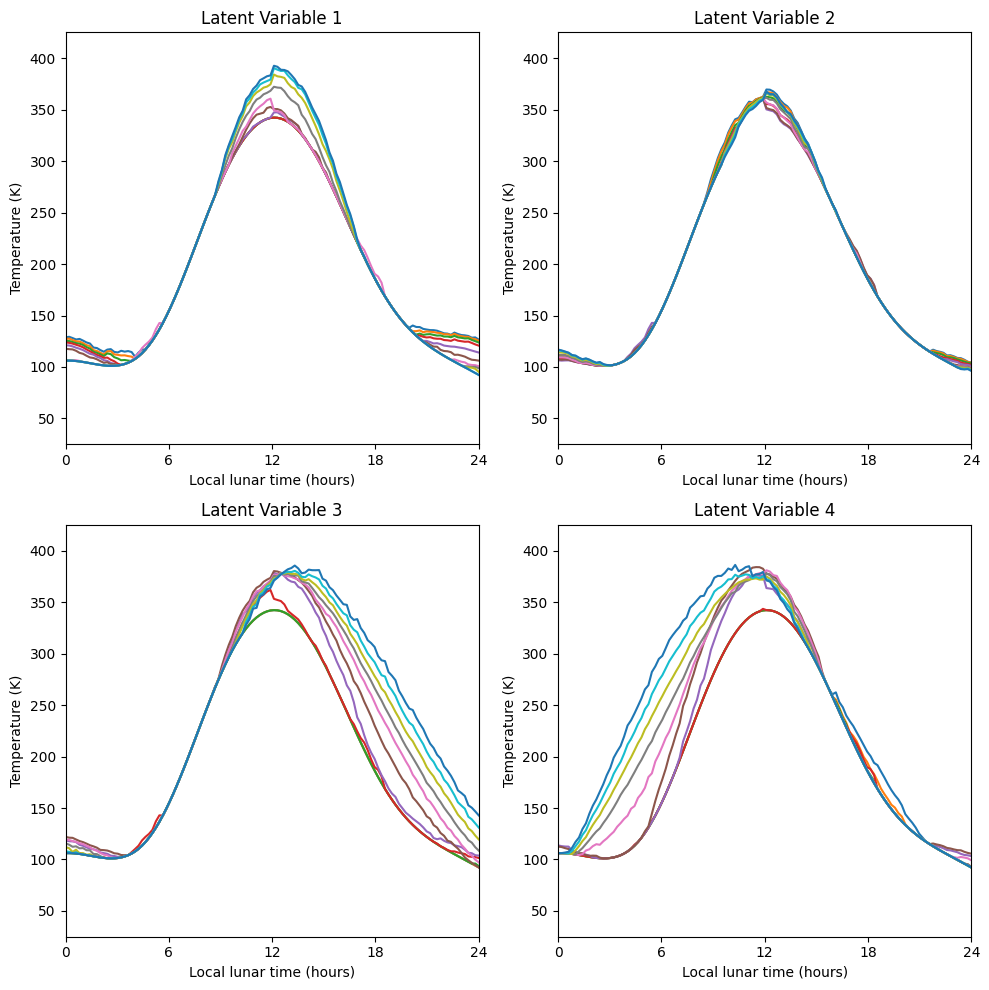

In [9]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)